<a href="https://colab.research.google.com/github/GabrielFePL/NLP-Fatec-Matao/blob/main/NlpPreProcessing_Exercise_30_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing - Fatec Matão

## Environment Configuration

In [1]:
!pip install transformers sentencepiece torch torchvision torchaudio
!pip install datasets scikit-learn matplotlib seaborn
!pip install nltk gensim pyLDAvis
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; py

In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, TrainingArguments, Trainer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pandas as pd
from datasets import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import spacy

In [8]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
bertimbau = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

In [10]:
classifier = AutoModelForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels = 2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
nlp = spacy.load("pt_core_news_sm")

## Embedding Generation

In [12]:
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = bertimbau(**inputs)
    embedding = outputs.last_hidden_state[:,0,:].numpy()
    return embedding

In [13]:
sent1 = "Eu fui ao banco sacar dinheiro."
sent2 = "Sentei no banco da praça."
emb1 = get_embedding(sent1)
emb2 = get_embedding(sent2)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [14]:
similarity = cosine_similarity(emb1, emb2)[0][0]
print(f"Similaridade semântica entre frases com 'banco': {similarity:.4f}")

Similaridade semântica entre frases com 'banco': 0.8864


## Fine-Tuning for Review Classification

In [22]:
data = {
    "text": [
        "O produto é ótimo, superou minhas expectativas!",
        "Horrível, não funciona de jeito nenhum.",
        "Entrega rápida e embalagem excelente.",
        "Qualidade péssima, não recomendo.",
        "Muito bom custo-benefício."
    ],
    "label": [1, 0, 1, 0, 1]
}

df = pd.DataFrame(data)

dataset = Dataset.from_pandas(df)

In [23]:
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=64)

In [26]:
tokenized = dataset.map(tokenize_batch, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
dataloader = DataLoader(tokenized, batch_size=2, shuffle=True)

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [27]:
optimizer = optim.AdamW(classifier.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.to(device)
classifier.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [29]:
epochs = 2
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = classifier(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.4f}")

Epoch 1/2 - Loss: 0.7589
Epoch 2/2 - Loss: 0.5243


## Topic Identification (LDA)

In [30]:
reviews = [
    "A entrega foi rápida e o produto é ótimo.",
    "Não gostei da qualidade, muito ruim.",
    "O preço está justo e a embalagem veio boa.",
    "Produto excelente, mas a entrega demorou."
]

In [31]:
stop_words = set(stopwords.words("portuguese"))
texts = [[word for word in review.lower().split() if word not in stop_words] for review in reviews]

In [32]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [33]:
lda = LdaModel(corpus=corpus, num_topics=2, id2word=dictionary, passes=10)
topics = lda.print_topics()
print("Tópicos principais:\n", topics)

Tópicos principais:
 [(0, '0.139*"entrega" + 0.139*"produto" + 0.083*"demorou." + 0.083*"excelente," + 0.083*"rápida" + 0.083*"ótimo." + 0.083*"qualidade," + 0.083*"gostei" + 0.083*"ruim." + 0.028*"boa."'), (1, '0.124*"justo" + 0.124*"preço" + 0.124*"veio" + 0.123*"embalagem" + 0.123*"boa." + 0.043*"produto" + 0.043*"ruim." + 0.043*"entrega" + 0.043*"gostei" + 0.043*"qualidade,"')]


## Sentiment Analysis per Time

In [34]:
data = {
    "data": pd.date_range("2023-01-01", periods=6, freq="M"),
    "review": [
        "Muito bom, adorei o produto.",
        "Horrível, não funciona.",
        "Entrega rápida, gostei.",
        "Não presta, perdi dinheiro.",
        "Excelente qualidade.",
        "Demorou, mas é bom."
    ]
}

df = pd.DataFrame(data)

/tmp/ipython-input-1744573172.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "data": pd.date_range("2023-01-01", periods=6, freq="M"),


In [36]:
def classify_review(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = classifier(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    label = torch.argmax(probs).item()
    return "Positivo" if label == 1 else "Negativo"

In [37]:
df["sentimento"] = df["review"].apply(classify_review)

In [38]:
sent_count = df.groupby(["data","sentimento"]).size().unstack().fillna(0)

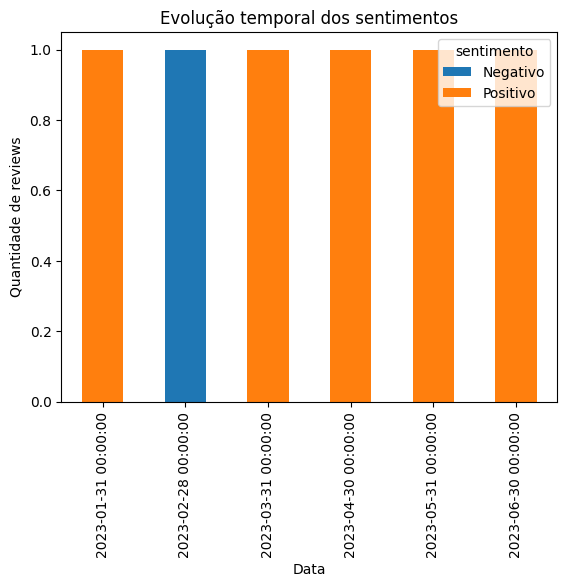

In [40]:
sent_count.plot(kind="bar", stacked=True)
plt.title("Evolução temporal dos sentimentos")
plt.xlabel("Data")
plt.ylabel("Quantidade de reviews")
plt.show()

## Aspects Extraction

In [41]:
def extract_aspects(text):
    doc = nlp(text)
    aspectos = [token.text for token in doc if token.dep_ in ("nsubj", "dobj", "amod")]
    return aspectos

In [42]:
for r in reviews:
    print(f"Review: {r}")
    print("Aspectos:", extract_aspects(r))
    print("-"*50)

Review: A entrega foi rápida e o produto é ótimo.
Aspectos: ['entrega', 'produto']
--------------------------------------------------
Review: Não gostei da qualidade, muito ruim.
Aspectos: ['ruim']
--------------------------------------------------
Review: O preço está justo e a embalagem veio boa.
Aspectos: ['preço', 'embalagem']
--------------------------------------------------
Review: Produto excelente, mas a entrega demorou.
Aspectos: ['excelente', 'entrega']
--------------------------------------------------
